In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import ttest_ind, f_oneway

import sys
sys.path.append("../helpers")

from helpers import run_eda_test, plot_multiple_hists


# 1. Introduction

#### We will be using a dataset of student performance attributes, the goal of our analysis is to determine based on this set which attributes are important in determining student academic performance. 

# 2. Data Loading and Overview

In [17]:
students = pd.read_csv('../datasets/Student_performance_data _.csv')

In [18]:
students.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [19]:
students.drop(columns=['StudentID'], inplace=True)

In [20]:
students.describe()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,2.983696
std,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.233908
min,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


In [21]:
students.dtypes

Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
GPA                  float64
GradeClass           float64
dtype: object

In [22]:
students.isnull().sum()

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

| Feature | Description |
|--------|-------------|
| **StudentID** | Unique identifier for each student (1001–3392). |
| **Age** | Age of the student (15–18 years). |
| **Gender** | 0 = Male, 1 = Female |
| **Ethnicity** | 0 = Caucasian, 1 = African American, 2 = Asian, 3 = Other |
| **ParentalEducation** | 0 = None, 1 = High School, 2 = Some College, 3 = Bachelor's, 4 = Higher |
| **StudyTimeWeekly** | Hours spent studying per week (0–20). |
| **Absences** | Number of school absences per year (0–30). |
| **Tutoring** | 0 = No, 1 = Yes |
| **ParentalSupport** | 0 = None, 1 = Low, 2 = Moderate, 3 = High, 4 = Very High |
| **Extracurricular** | 0 = No, 1 = Yes |
| **Sports** | 0 = No, 1 = Yes |
| **Music** | 0 = No, 1 = Yes |
| **Volunteering** | 0 = No, 1 = Yes |
| **GPA** | Grade Point Average (2.0–4.0). |
| **GradeClass** | 0=A, 1=B, 2=C, 3=D, 4=F |

### The dataset contains no missing values, but several categorical features are represented using numeric codes (e.g., 0–3 for Ethnicity, 0–4 for ParentalSupport). Although these codes are numeric, they do not represent continuous or ordinal quantities. To avoid misleading correlations and ensure proper preprocessing later, we explicitly convert these columns to the category dtype.

### This conversion:
- preserves the original values
- clarifies that these features are nominal categories
- prevents them from being incorrectly treated as numeric during EDA
- ensures that later encoding methods (e.g., pd.get_dummies) handle them correctly

In [23]:
categorical_cols = [
    "Gender",
    "Ethnicity",
    "ParentalEducation",
    "ParentalSupport",
    "Tutoring",
    "Extracurricular",
    "Sports",
    "Music",
    "Volunteering"
]
students[categorical_cols] = students[categorical_cols].astype("category")

In [24]:
students_catogory = students.select_dtypes(include=['category'])
students_numeric = students.select_dtypes(include="number")
students.dtypes

Age                     int64
Gender               category
Ethnicity            category
ParentalEducation    category
StudyTimeWeekly       float64
Absences                int64
Tutoring             category
ParentalSupport      category
Extracurricular      category
Sports               category
Music                category
Volunteering         category
GPA                   float64
GradeClass            float64
dtype: object

# 3. Data Visualization

In [25]:
# Mapping dictionaries for each categorical column
label_maps = {
    "Gender": {
        0: "Male",
        1: "Female"
    },
    "Ethnicity": {
        0: "Caucasian",
        1: "African American",
        2: "Asian",
        3: "Other"
    },
    "ParentalEducation": {
        0: "None",
        1: "High School",
        2: "Some College",
        3: "Bachelor's",
        4: "Higher"
    },
    "ParentalSupport": {
        0: "None",
        1: "Low",
        2: "Moderate",
        3: "High",
        4: "Very High"
    },
    "Tutoring": {0: "No", 1: "Yes"},
    "Extracurricular": {0: "No", 1: "Yes"},
    "Sports": {0: "No", 1: "Yes"},
    "Music": {0: "No", 1: "Yes"},
    "Volunteering": {0: "No", 1: "Yes"},
    "GradeClass": {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "F"
    }
}


# Column descriptions (based on your dataset dictionary)
column_descriptions = {
    "StudentID": "Unique identifier for each student.",
    "Age": "Age of the student.",
    "Gender": "Student gender.",
    "Ethnicity": "Student ethnicity.",
    "ParentalEducation": "Highest level of parental education.",
    "StudyTimeWeekly": "Average weekly study time in hours.",
    "Absences": "Total number of school absences.",
    "Tutoring": "Indicates whether the student receives tutoring.",
    "ParentalSupport": "Level of parental support for the student.",
    "Extracurricular": "Participation in extracurricular activities.",
    "Sports": "Participation in sports programs.",
    "Music": "Participation in music activities.",
    "Volunteering": "Participation in volunteering or community service.",
    "GPA": "Student’s Grade Point Average.",
    "GradeClass": "Overall academic performance represented by letter grade."
}



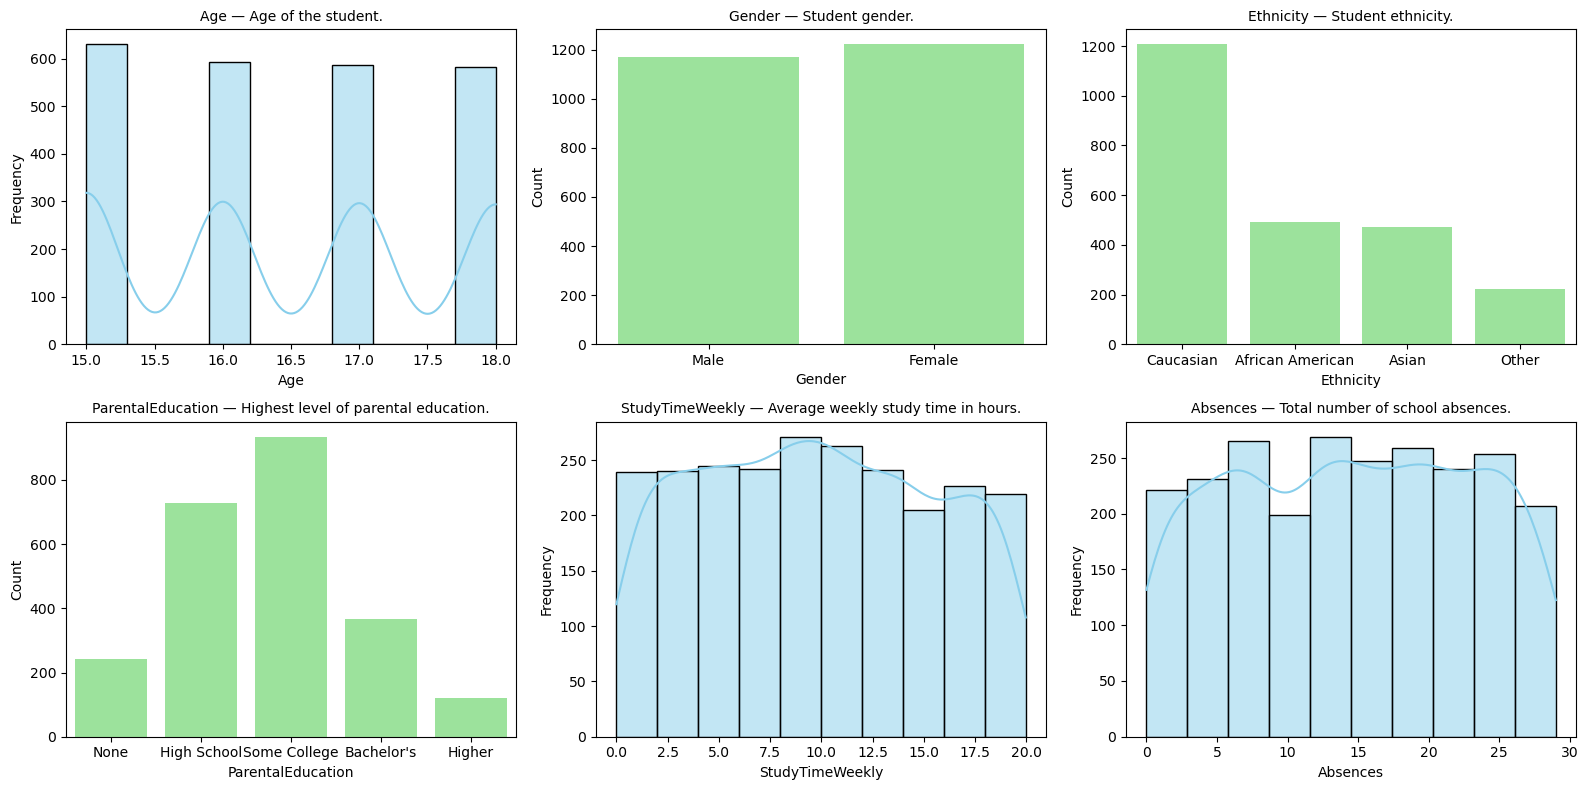

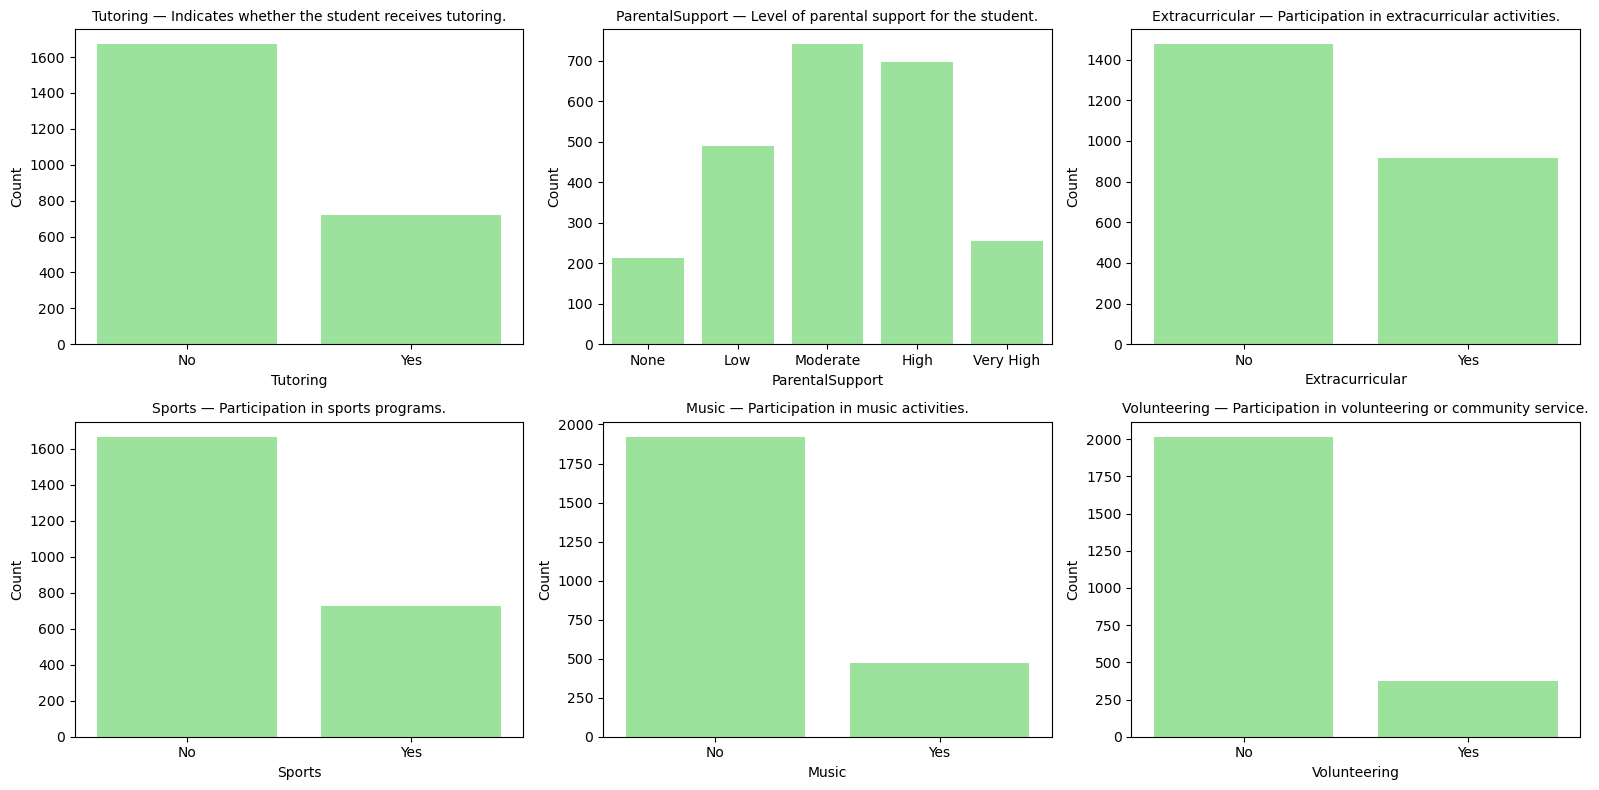

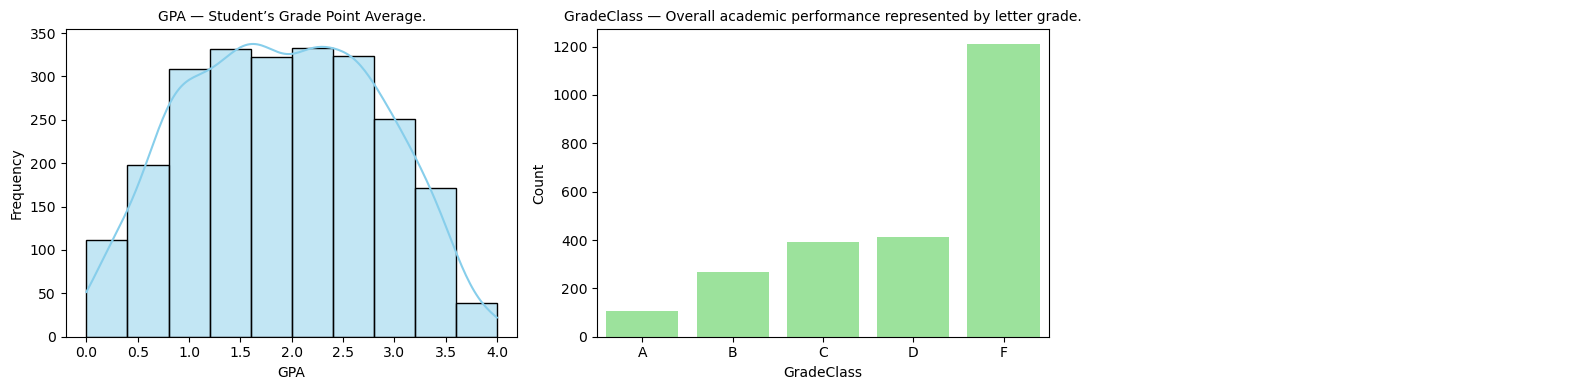

In [26]:
plot_multiple_hists(
    students,
    columns=students.columns[:6],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 8)
)
plot_multiple_hists(
    students,
    columns=students.columns[6:12],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 8)
)

plot_multiple_hists(
    students,
    columns=students.columns[12:],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 4)
)

### Descriptive Statistics for Each Feature

- **Age:** Uniform distribution between ages 15–18 with no dominant age group.  
- **Gender:** Roughly balanced split between male and female students.  
- **Ethnicity:** Imbalanced, with Caucasian students forming the majority; “Other” least represented.  
- **ParentalEducation:** Skewed toward “Some College” and “High School”; very few in “Higher” or “None.”  
- **StudyTimeWeekly:** Evenly spread across 0–20 hours with no dominant cluster.  
- **Absences:** Ranges from 0–30 days with a fairly uniform distribution.  
- **Tutoring:** Most students do not receive tutoring; small minority does.  
- **ParentalSupport:** Distributed across all five levels, with “Moderate” and “High” most common.  
- **Extracurricular:** Majority of students do not participate in extracurricular activities.  
- **Sports:** Strong imbalance, with many more non-participants than participants.  
- **Music:** Highly imbalanced, with most students not involved in music activities.  
- **Volunteering:** Majority of students do not volunteer.  
- **GPA:** Approximately symmetric distribution from 2.0–4.0, peaking mid–high GPA.  
- **GradeClass:** Strongly imbalanced, with “F” the most common grade class.

# 4. Exploratory Data Analysis

<bound method NDFrame.describe of                       Age  StudyTimeWeekly  Absences       GPA  GradeClass
Age              1.000000        -0.006800 -0.011511  0.000275   -0.006250
StudyTimeWeekly -0.006800         1.000000  0.009326  0.179275   -0.134131
Absences        -0.011511         0.009326  1.000000 -0.919314    0.728633
GPA              0.000275         0.179275 -0.919314  1.000000   -0.782835
GradeClass      -0.006250        -0.134131  0.728633 -0.782835    1.000000>


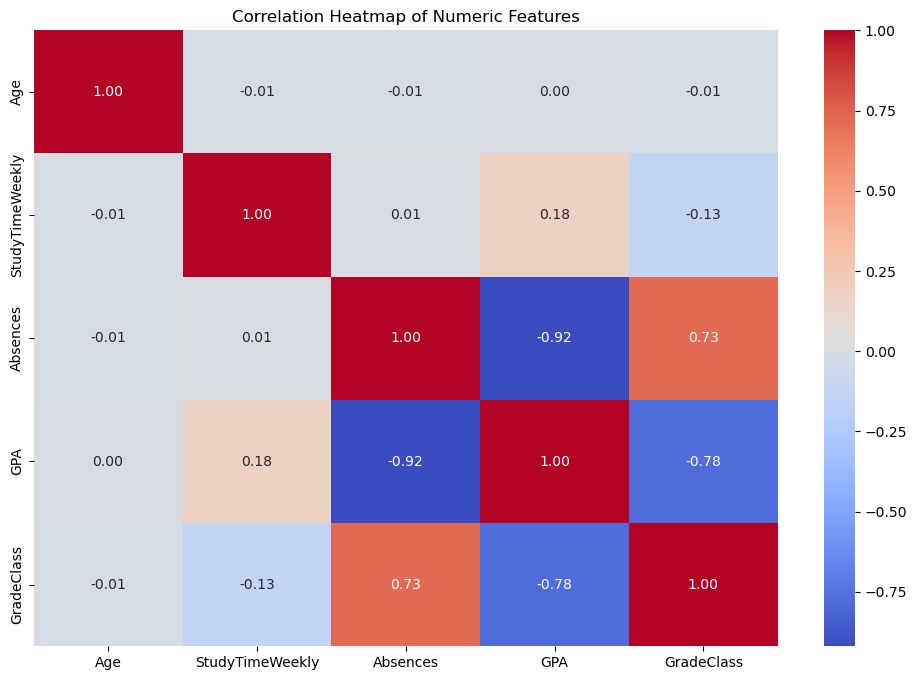

In [27]:
# Compute correlation matrix
corr = students_numeric.corr()

print(corr.describe)
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Interpretation of Heatmap Relationships
- It is surprising to see that StudyTimeWeekly shows only a negligible correlation with GPA, suggesting that simply spending more hours studying does not strongly predict academic performance in this dataset.
- In contrast, and consistent with expectations, Absences show a very strong negative correlation with GPA, indicating that missing classes is one of the most influential factors associated with lower academic performance.
- Additionally, GPA and GradeClass are highly correlated because GradeClass is directly derived from GPA. To prevent data leakage and redundancy, GradeClass will be removed during preprocessing.

In [28]:
students_catogory.describe()

,Gender,Ethnicity,ParentalEducation,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
count,2392,2392,2392,2392,2392,2392,2392,2392,2392
unique,2,4,5,2,5,2,2,2,2
top,1,0,2,0,2,0,0,0,0
freq,1222,1207,934,1671,740,1475,1666,1921,2016


## 🧪 Statistical Tests Used: T-Test and ANOVA, conventional alpha of 0.05
### Independent Samples T-Test (Binary Categorical Variables)
- We use t-tests when comparing mean GPA between two groups (e.g., Gender, Tutoring, Sports).
- A t-test evaluates whether the difference in mean GPA is large enough relative to natural variability within each group to conclude that the groups truly differ rather than the difference arising by chance.
- The t-statistic is not simply the difference in group means; it also adjusts for within-group variability, sample size, and the standard error of the difference.
- This allows us to determine whether the GPA difference between two categories is statistically meaningful.

### One-Way ANOVA (Categorical Variables with 3 or More Groups)
- We use one-way ANOVA when comparing mean GPA across three or more categories (e.g., Ethnicity, ParentalEducation, ParentalSupport).
- ANOVA evaluates whether at least one group mean differs from the others by comparing variation between groups to variation within groups.
- If the between-group variation is substantially larger than the within-group variation, the F-statistic becomes large, indicating that not all group means are equal.
- ANOVA is necessary because it avoids inflated Type I error from running multiple t-tests, properly handles 3+ group comparisons in a single unified test, and determines whether meaningful group differences exist before examining specific pairs.
    - A Type I error occurs when we incorrectly conclude that a significant difference exists between groups when it actually does not — essentially a false positive.

EDA Analysis: GPA by Gender

Running Independent Samples T-Test...

Group 1 mean: 1.894
Group 0 mean: 1.919
T-statistic: -0.6532
P-value: 0.513668
Result: No significant difference between groups (p ≥ 0.05).


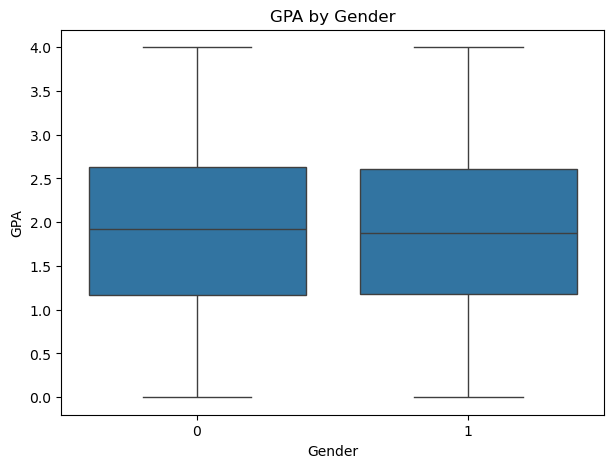



EDA Analysis: GPA by Tutoring

Running Independent Samples T-Test...

Group 1 mean: 2.108
Group 0 mean: 1.819
T-statistic: 7.1725
P-value: 0.000000
Result: Significant difference between groups (p < 0.05).


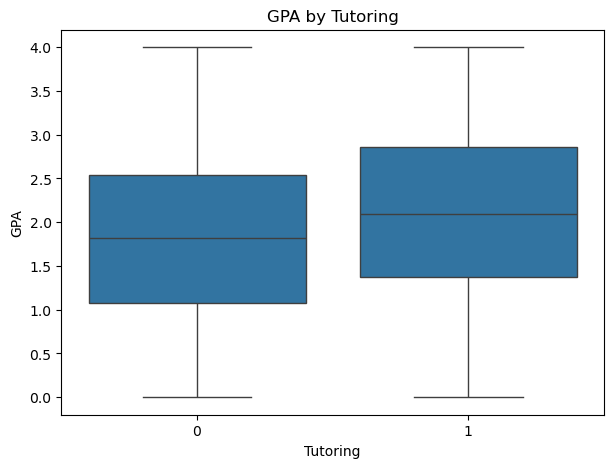



EDA Analysis: GPA by Extracurricular

Running Independent Samples T-Test...

Group 0 mean: 1.838
Group 1 mean: 2.015
T-statistic: -4.6086
P-value: 0.000004
Result: Significant difference between groups (p < 0.05).


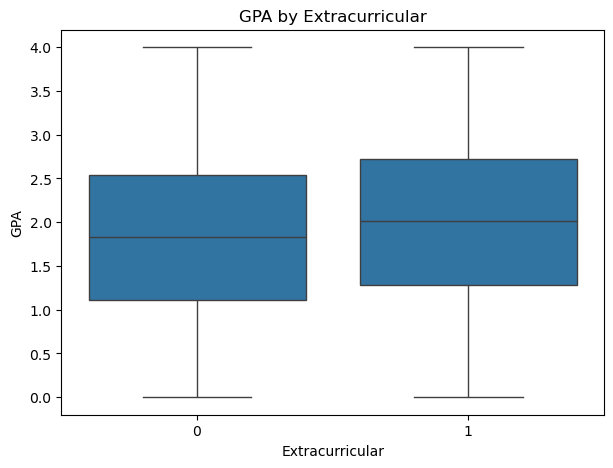



EDA Analysis: GPA by Sports

Running Independent Samples T-Test...

Group 0 mean: 1.871
Group 1 mean: 1.986
T-statistic: -2.8514
P-value: 0.004416
Result: Significant difference between groups (p < 0.05).


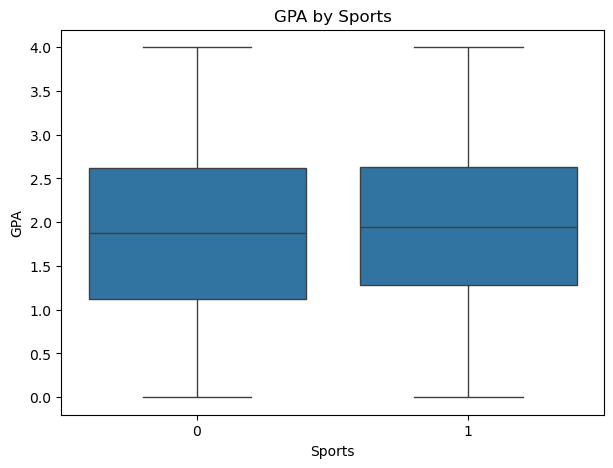



EDA Analysis: GPA by Music

Running Independent Samples T-Test...

Group 1 mean: 2.042
Group 0 mean: 1.873
T-statistic: 3.5971
P-value: 0.000344
Result: Significant difference between groups (p < 0.05).


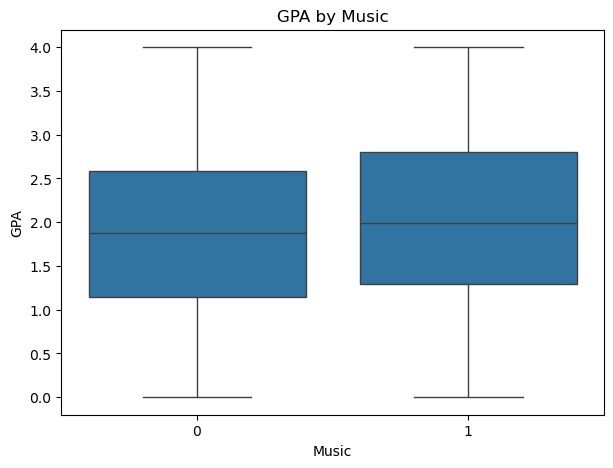



EDA Analysis: GPA by Volunteering

Running Independent Samples T-Test...

Group 0 mean: 1.905
Group 1 mean: 1.913
T-statistic: -0.1611
P-value: 0.872068
Result: No significant difference between groups (p ≥ 0.05).


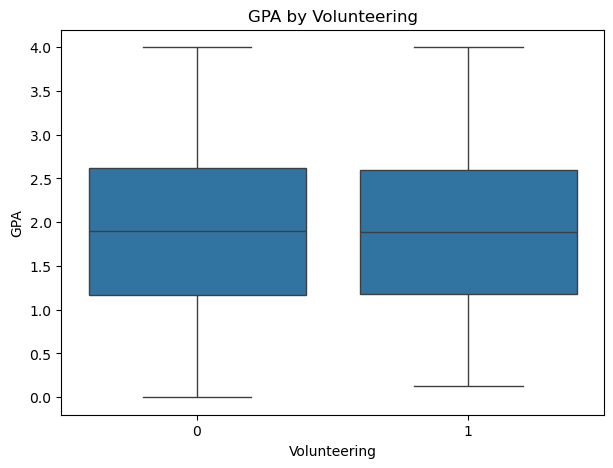



EDA Analysis: GPA by Ethnicity

Running One-Way ANOVA...

Group Means:
  0: 1.876
  2: 1.922
  1: 1.946
  3: 1.948

F-statistic: 0.9581
P-value: 0.411585
Result: No significant differences (p ≥ 0.05).


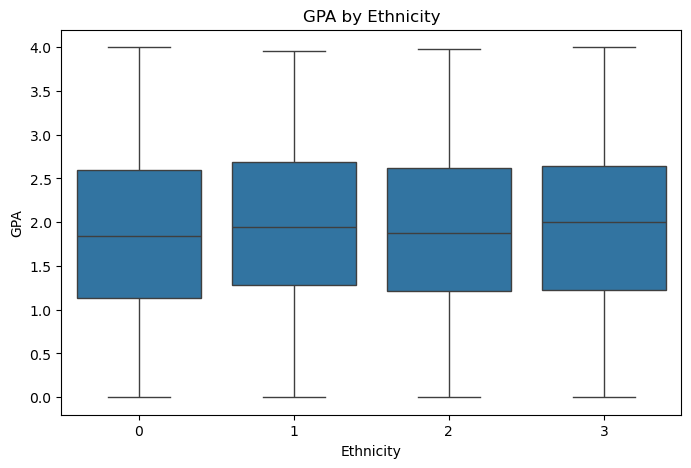



EDA Analysis: GPA by ParentalEducation

Running One-Way ANOVA...

Group Means:
  2: 1.930
  1: 1.944
  3: 1.809
  4: 1.816
  0: 1.893

F-statistic: 1.8081
P-value: 0.124484
Result: No significant differences (p ≥ 0.05).


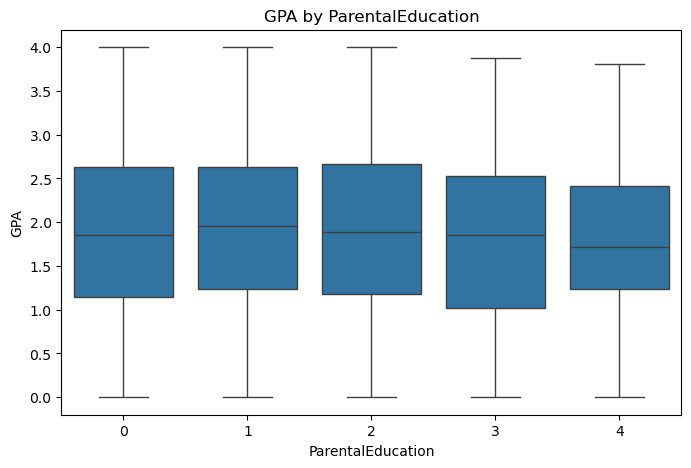



EDA Analysis: GPA by ParentalSupport

Running One-Way ANOVA...

Group Means:
  2: 1.884
  1: 1.756
  3: 2.042
  4: 2.192
  0: 1.540

F-statistic: 22.7235
P-value: 0.000000
Result: Significant differences among groups (p < 0.05).


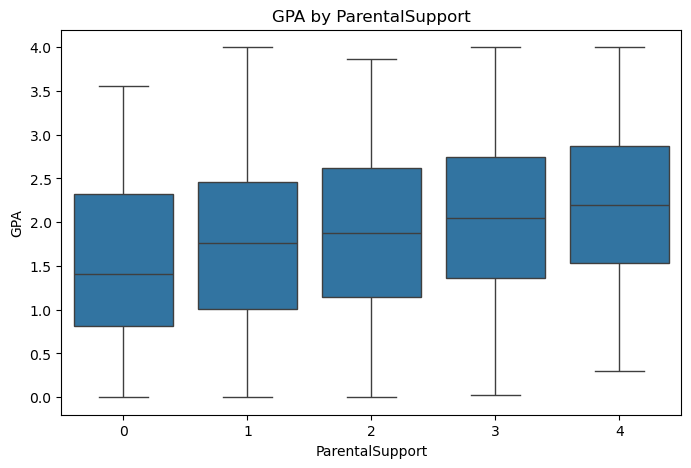

In [29]:
# Binary (t-test)
run_eda_test(students, "Gender", "GPA")
run_eda_test(students, "Tutoring", "GPA")
run_eda_test(students, "Extracurricular", "GPA")
run_eda_test(students, "Sports", "GPA")
run_eda_test(students, "Music", "GPA")
run_eda_test(students, "Volunteering", "GPA")

# Multi-category (ANOVA)
run_eda_test(students, "Ethnicity", "GPA")
run_eda_test(students, "ParentalEducation", "GPA")
run_eda_test(students, "ParentalSupport", "GPA")

### Summary of EDA Findings

#### Based on the exploratory data analysis performed, several categorical and numerical features show statistically significant relationships with student GPA.

### Significant Categorical Predictors of GPA
- **ParentalSupport** — ANOVA results indicate strong differences in mean GPA across support levels, with higher parental support consistently associated with higher GPA.
- **Music Participation** — Students involved in music activities show significantly different GPA distributions compared to those who are not.
- **Sports Participation** — Students who participate in sports demonstrate significantly different GPA outcomes relative to non-athletes.
- **Extracurricular Activities** — Involvement in extracurricular activities is associated with meaningful differences in GPA.
- **Tutoring** — Receiving tutoring is significantly related to GPA, with tutored students showing different academic performance on average.

### Significant Numerical Predictor of GPA
- **Absences** — There is a very strong negative correlation between absences and GPA (r ≈ -0.92), indicating that higher absences are strongly associated with lower academic performance.

### Overall Interpretation
The EDA results suggest that both **student engagement activities** (music, sports, extracurriculars, tutoring) and **family-related support factors** (parental support) play important roles in academic achievement. However, **absences** emerge as the single strongest predictor, demonstrating that attendance has a substantial impact on student GPA. These findings highlight the importance of both behavioral and environmental factors in influencing student success.